In [56]:
import numpy as np
import pandas as pd
import spacy
import random
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import nltk
nltk.download("punkt")
from nltk.probability import FreqDist
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchmetrics import F1Score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [42]:
seed = 2023

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Данные

## Считывание данных

In [43]:
df_false = pd.read_csv("Fake.csv")
df_true = pd.read_csv("True.csv")
df_false["label"] = 0
df_true["label"] = 1
df_true.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [44]:
df_false.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [45]:
# remove first 3 words, because they are the same for true news
df_true["text"] = df_true["text"].apply(lambda x: ' '.join(x.split(' ')[3:]))
df = pd.concat([df_true, df_false], ignore_index=True)

In [46]:
df['data'] = df['text'] + " " + df['title']
df = df.drop(['date', 'subject', 'title', 'text'],axis=1)
df

,label,data
0,1,The head of a conservative Republican faction ...
1,1,Transgender people will be allowed for the fir...
2,1,The special counsel investigation of links bet...
3,1,Trump campaign adviser George Papadopoulos tol...
4,1,President Donald Trump called on the U.S. Post...
...,...,...
44893,0,21st Century Wire says As 21WIRE reported earl...
44894,0,21st Century Wire says It s a familiar theme. ...
44895,0,Patrick Henningsen 21st Century WireRemember ...
44896,0,21st Century Wire says Al Jazeera America will...


## Предобработка

In [47]:
%%time
nlp = spacy.load("en_core_web_sm")
df['data'] = df['data'].apply(lambda x :[
        token.lemma_.lower() for token in nlp(x) if
        not token.is_stop
        and not token.is_punct
        and not token.is_digit
        and not token.like_email
        and not token.like_num
        and not token.is_space
    ])
df.head()

CPU times: total: 59min 35s
Wall time: 1h 2min 57s


,label,data
0,1,"[head, conservative, republican, faction, u.s...."
1,1,"[transgender, people, allow, time, enlist, u.s..."
2,1,"[special, counsel, investigation, link, russia..."
3,1,"[trump, campaign, adviser, george, papadopoulo..."
4,1,"[president, donald, trump, call, u.s., postal,..."


In [49]:
X_train, X_test, y_train, y_test = train_test_split(df['data'], df['label'], test_size=0.40, random_state=seed)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=seed)

## Составление словаря и превращение текста в эмбеддинги

In [54]:
train_corpus = list(X_train)
tokens = []
for text in tqdm(train_corpus):
  tokens.extend(text)
tokens_filtered = [word for word in tokens if word.isalnum()]

  0%|          | 0/26938 [00:00<?, ?it/s]

In [58]:
max_words = 10000
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [59]:
tokens_filtered_top[:10]

['s',
 'say',
 'trump',
 'president',
 'state',
 't',
 'year',
 'people',
 'new',
 'obama']

In [60]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

{'s': 1,
 'say': 2,
 'trump': 3,
 'president': 4,
 'state': 5,
 't': 6,
 'year': 7,
 'people': 8,
 'new': 9,
 'obama': 10,
 'clinton': 11,
 'tell': 12,
 'government': 13,
 'house': 14,
 'donald': 15,
 'republican': 16,
 'election': 17,
 'country': 18,
 'time': 19,
 'go': 20,
 'party': 21,
 'white': 22,
 'like': 23,
 'campaign': 24,
 'right': 25,
 'united': 26,
 'know': 27,
 'official': 28,
 'vote': 29,
 'come': 30,
 'report': 31,
 'news': 32,
 'call': 33,
 'include': 34,
 'law': 35,
 'want': 36,
 'group': 37,
 'take': 38,
 'work': 39,
 'states': 40,
 'hillary': 41,
 'day': 42,
 'video': 43,
 'think': 44,
 'support': 45,
 'week': 46,
 'court': 47,
 'security': 48,
 'american': 49,
 'attack': 50,
 'national': 51,
 'police': 52,
 'bill': 53,
 'need': 54,
 'political': 55,
 'ask': 56,
 'leader': 57,
 'woman': 58,
 'accord': 59,
 'russia': 60,
 'medium': 61,
 'win': 62,
 'administration': 63,
 'percent': 64,
 'way': 65,
 'plan': 66,
 'month': 67,
 'presidential': 68,
 'america': 69,
 'issue

In [61]:
len(vocabulary)

9999

In [70]:
# Заполнение паддинга нулями
def text_to_sequence(tokens, maxlen):
    result = []
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [73]:
max_len = 300
x_train = np.array([text_to_sequence(text, max_len) for text in tqdm(X_train)], dtype=np.int32)
x_test = np.array([text_to_sequence(text, max_len) for text in tqdm(X_test)], dtype=np.int32)
x_valid = np.array([text_to_sequence(text, max_len) for text in tqdm(X_valid)], dtype=np.int32)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_valid = np.array(y_valid)
x_train[:5,:]

  0%|          | 0/26938 [00:00<?, ?it/s]

  0%|          | 0/8980 [00:00<?, ?it/s]

  0%|          | 0/8980 [00:00<?, ?it/s]

array([[ 110, 3054,  134, ...,  266,   10,   43],
       [   0,    0,    0, ..., 6641,   69, 8893],
       [1340, 2468,   16, ...,  305,  376, 2004],
       [   3,   28,   46, ...,  107,  866,  756],
       [   0,    0,    0, ...,  140,  924, 4292]])

In [74]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Модели

## CNN Text Classification

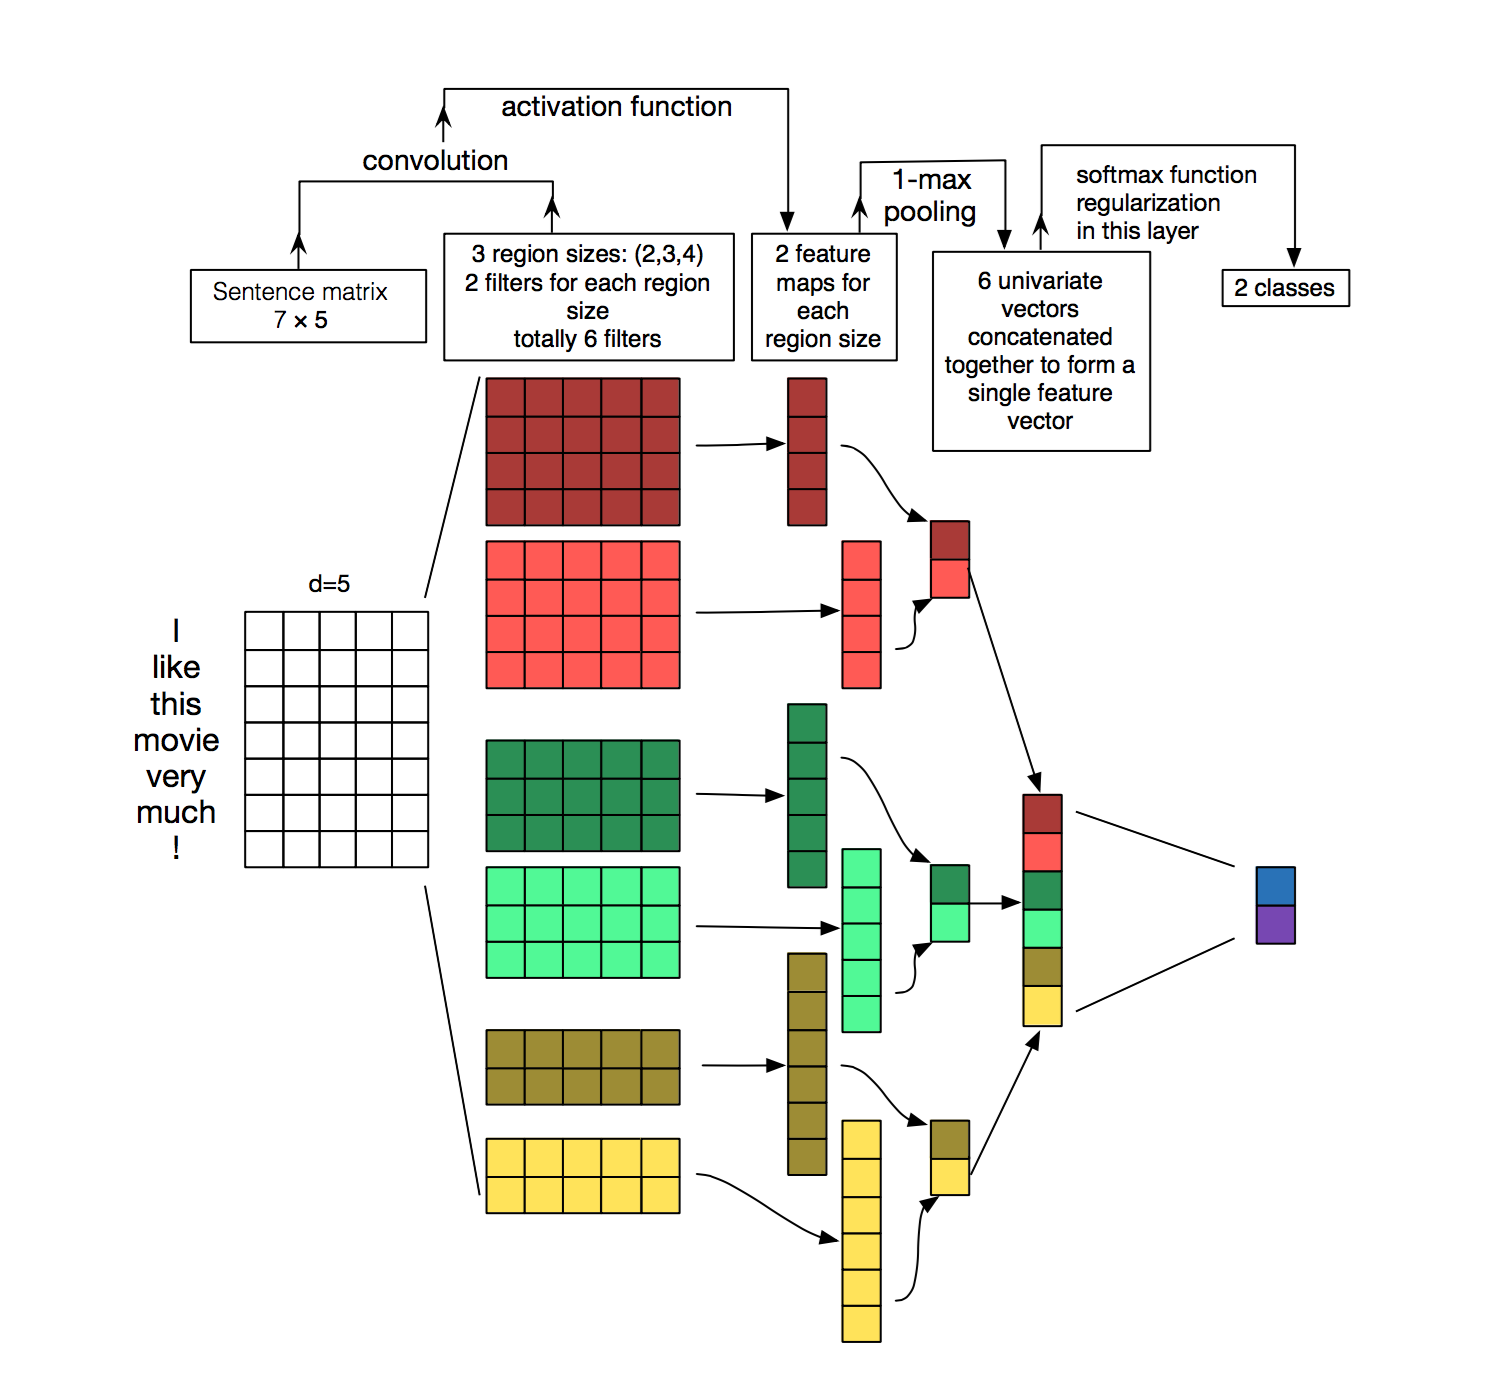

## LSTM



## Обучение модели

In [75]:
class ConvTextClassifier(nn.Module):
    def __init__(self, vocab_size=10000, embedding_dim=128, out_channel=128, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)

    def forward(self, x):
        output = self.embedding(x)
        output = output.permute(0, 2, 1) # bs, emb_dim, len
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        return output

In [76]:
class TextDataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        else:
          self.target = None
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else -1

        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.data)

In [79]:
import torch.nn as nn

class LSTMTextClassifier(nn.Module):
    def __init__(self, vocab_size=10000, embedding_dim=128, hid_size=64, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hid_size, batch_first=True)
        self.linear = nn.Linear(in_features=hid_size, out_features=num_classes)

    def forward(self, x):
        input_ix = torch.as_tensor(x).to(device)
        out = self.embedding(input_ix)
        out, (hn, cn) = self.lstm(out)
        out = self.linear(out)
        return out # output tensor should be of shape [batch_size, sequence_length, n_tokens]

In [80]:
batch_size = 256
epochs = 10

In [81]:
def train_model(model, epochs):
    print(model)
    print("Parameters:", sum([param.nelement() for param in model.parameters()]))

    model.to(device)
    f1 = F1Score(task="binary")
    f1.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
    criterion = nn.CrossEntropyLoss()

    train_dataset = TextDataWrapper(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    valid_dataset = TextDataWrapper(x_valid, y_valid)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

    loss_history = []
    model.train()
    for epoch in range(1,epochs+1):
        print(f"Train epoch {epoch}/{epochs}")
        temp_loss = []
        temp_metrics = []
        for i, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()

            data = data.to(device)
            target = target.to(device)
            output = model(data)

            loss = criterion(output, target)
            loss.backward()

            optimizer.step()
            temp_loss.append(loss.float().item())
            temp_metrics.append(f1(output.argmax(1), target).item())

        epoch_loss = np.array(temp_loss).mean()
        epoch_f1 = np.array(temp_metrics).mean()
        print(f'Loss: {epoch_loss}, f1 score: {epoch_f1}')

In [ ]:
train_model(ConvTextClassifier(), epochs)

In [ ]:
train_model(LSTMTextClassifier(), epochs)